# Step 1.3 - Add population density to the Copenhagen carall Network
## Project: Growing Urban Bicycle Networks

This notebook loads population density data from Copenhagen in 2019, and applies a fraction of this to the nearest edges in the carall network. a population density attribute 'pop_den_attr' is added to the network, represented as edgelength multiplied with the fraction of the population density for the given street. For edges that are not assigned this attribute, the average edgelength multiplied with the average population density in the network, is assigned

pop_den_attr_unassigned = 7.193810421653459

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-09  
Last modified: 2021-03-10

## Preliminaries

### Parameters

In [1]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
#%run -i setup.py
%run -i setupCPH.py
import pandas as pd
from sklearn import preprocessing
%load_ext watermark
%watermark -n -v -m -g -iv
import statistics

Loaded PATH.

Setup finished.

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 8.5.0

Compiler    : Clang 9.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 40ca8c59f7b566fe66060109a7898e6e783a4eca

sklearn   : 1.1.2
csv       : 1.0
geopandas : 0.11.1
fiona     : 1.8.21
pyproj    : 3.4.0
numpy     : 1.23.3
sys       : 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]
pandas    : 1.4.4
watermark : 2.3.1
json      : 2.0.9
networkx  : 2.8.6
osmnx     : 0.16.2
igraph    : 0.9.1
matplotlib: 3.6.0
geojson   : 2.5.0
shapely   : 1.8.4
osgeo     : 3.2.1



### Functions

In [3]:
%run -i functions.py

Loaded functions.



## Load carall graph

In [4]:
G_carall = ox.load_graphml('../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml')

## Load population density data, convert to fractions and normalise

In [5]:
pop_den_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/dnk_pd_2019_1km_ASCII_XYZ.csv")
#pop_den_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/dnk_pd_2019_1km_ASCII_XYZ_small.csv")

#convert to fraction. All pop densities are added 1 to avoid division by zero (if zero density).
pop_den_df['pop_den_attr']= pop_den_df['Z']
for i in range(len(pop_den_df['Z'])):
    pop_den_df['pop_den_attr'].iloc[i] = 1.0/float(pop_den_df['pop_den_attr'].iloc[i]+1)
    #Normalise population density
print(pop_den_df.drop(pop_den_df.columns[[0,1,2]], axis=1))
x = pop_den_df.drop(pop_den_df.columns[[0,1,2]], axis=1) #returns a numpy array of only bikecounts
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1.0))
x_scaled = min_max_scaler.fit_transform(x)
pop_den_norm_df = pd.DataFrame(x_scaled)

for i in range(len(pop_den_df)):
    pop_den_df['pop_den_attr'].iloc[i] = pop_den_norm_df.iloc[i]

pop_den_df.rename(columns = {'X':'long', 'Y':'lat','Z':'pop_den'}, inplace = True)

       pop_den_attr
0          0.131340
1          0.136312
2          0.127312
3          0.119582
4          0.132795
...             ...
94672      0.030779
94673      0.032927
94674      0.141894
94675      0.100162
94676      0.070227

[94677 rows x 1 columns]


In [9]:
max(pop_den_df['pop_den_attr'])


1.0000000000000002

## Add 'pop_den_attr' to carall graph

In [116]:


#Initially set to 0, as we otherwise would get the average population density for whole denmark
pop_den_attr_unassigned = 0.0

nx.set_edge_attributes(G_carall, pop_den_attr_unassigned, 'pop_den_attr')


#With haversine, should have less edges in plot
for i in range(len(pop_den_df)):
    n = ox.distance.get_nearest_node(G_carall, [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
    if haversine([pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long], (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
        ne = ox.distance.get_nearest_edge(G_carall, [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
        pcount = pop_den_df.iloc[i].pop_den_attr
        nx.set_edge_attributes(G_carall, {ne: {"pop_den_attr": pcount }})
    

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
pop_len_attr_dict = nx.get_edge_attributes(G_carall, "pop_den_attr")

#to get the mean population density from copenhagen edges we calculate the mean of assigned edges and
#assign each edge their length multiplied by the fraction of population density. 
# The pop_den_df includes population densities of a larger area than copenhagen, and we wish to only
#include the popultaion densities of copenhagen. Therefor we extract the from the network.
pop_den_attr_unassigned = statistics.mean([x for x in list(pop_len_attr_dict.values()) if x!= pop_den_attr_unassigned])

#Get the mean edgelength to create an attribute for unassigned edges.
edges_len_dict = nx.get_edge_attributes(G_carall, 'length')
edges_len_mean = statistics.mean([k for k in edges_len_dict.values()])

#An attribute for unassigned edges
pop_den_attr_unassigned = pop_den_attr_unassigned * edges_len_mean

with open('../../bikenwgrowth_external/data/copenhagen/bikedata/unassigned_pop_den_attr.pkl', 'wb') as f:
    pickle.dump(pop_den_attr_unassigned, f)

# For all edges in the carall graph we check if population density is still zero, meaning that this is an unassigned 
# edge. then we assign it the mean edgelength * the mean population density

for e in G_carall.edges():
    a,b=e
    popden = G_carall.get_edge_data(a,b,0)['pop_den_attr']
    edgelength = G_carall.get_edge_data(a,b,0)['length']
    if popden ==0.0:
        attr = pop_den_attr_unassigned
    else:
        attr = popden * edgelength
    nx.set_edge_attributes(G_carall, {(a,b,0): {"pop_den_attr": attr }})


#Get the finel edge dict
pop_len_attr_dict = nx.get_edge_attributes(G_carall, "pop_den_attr")

ox_to_csv(G_carall, PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall')

ox_to_csv(ox.simplify_graph(G_carall), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")

ox.save_graphml(G_carall, "../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml")

with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_dict_pop_den_attr.pkl', 'wb') as f:
    pickle.dump(pop_len_attr_dict, f)



## Plot nearest edges of population density counts 

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


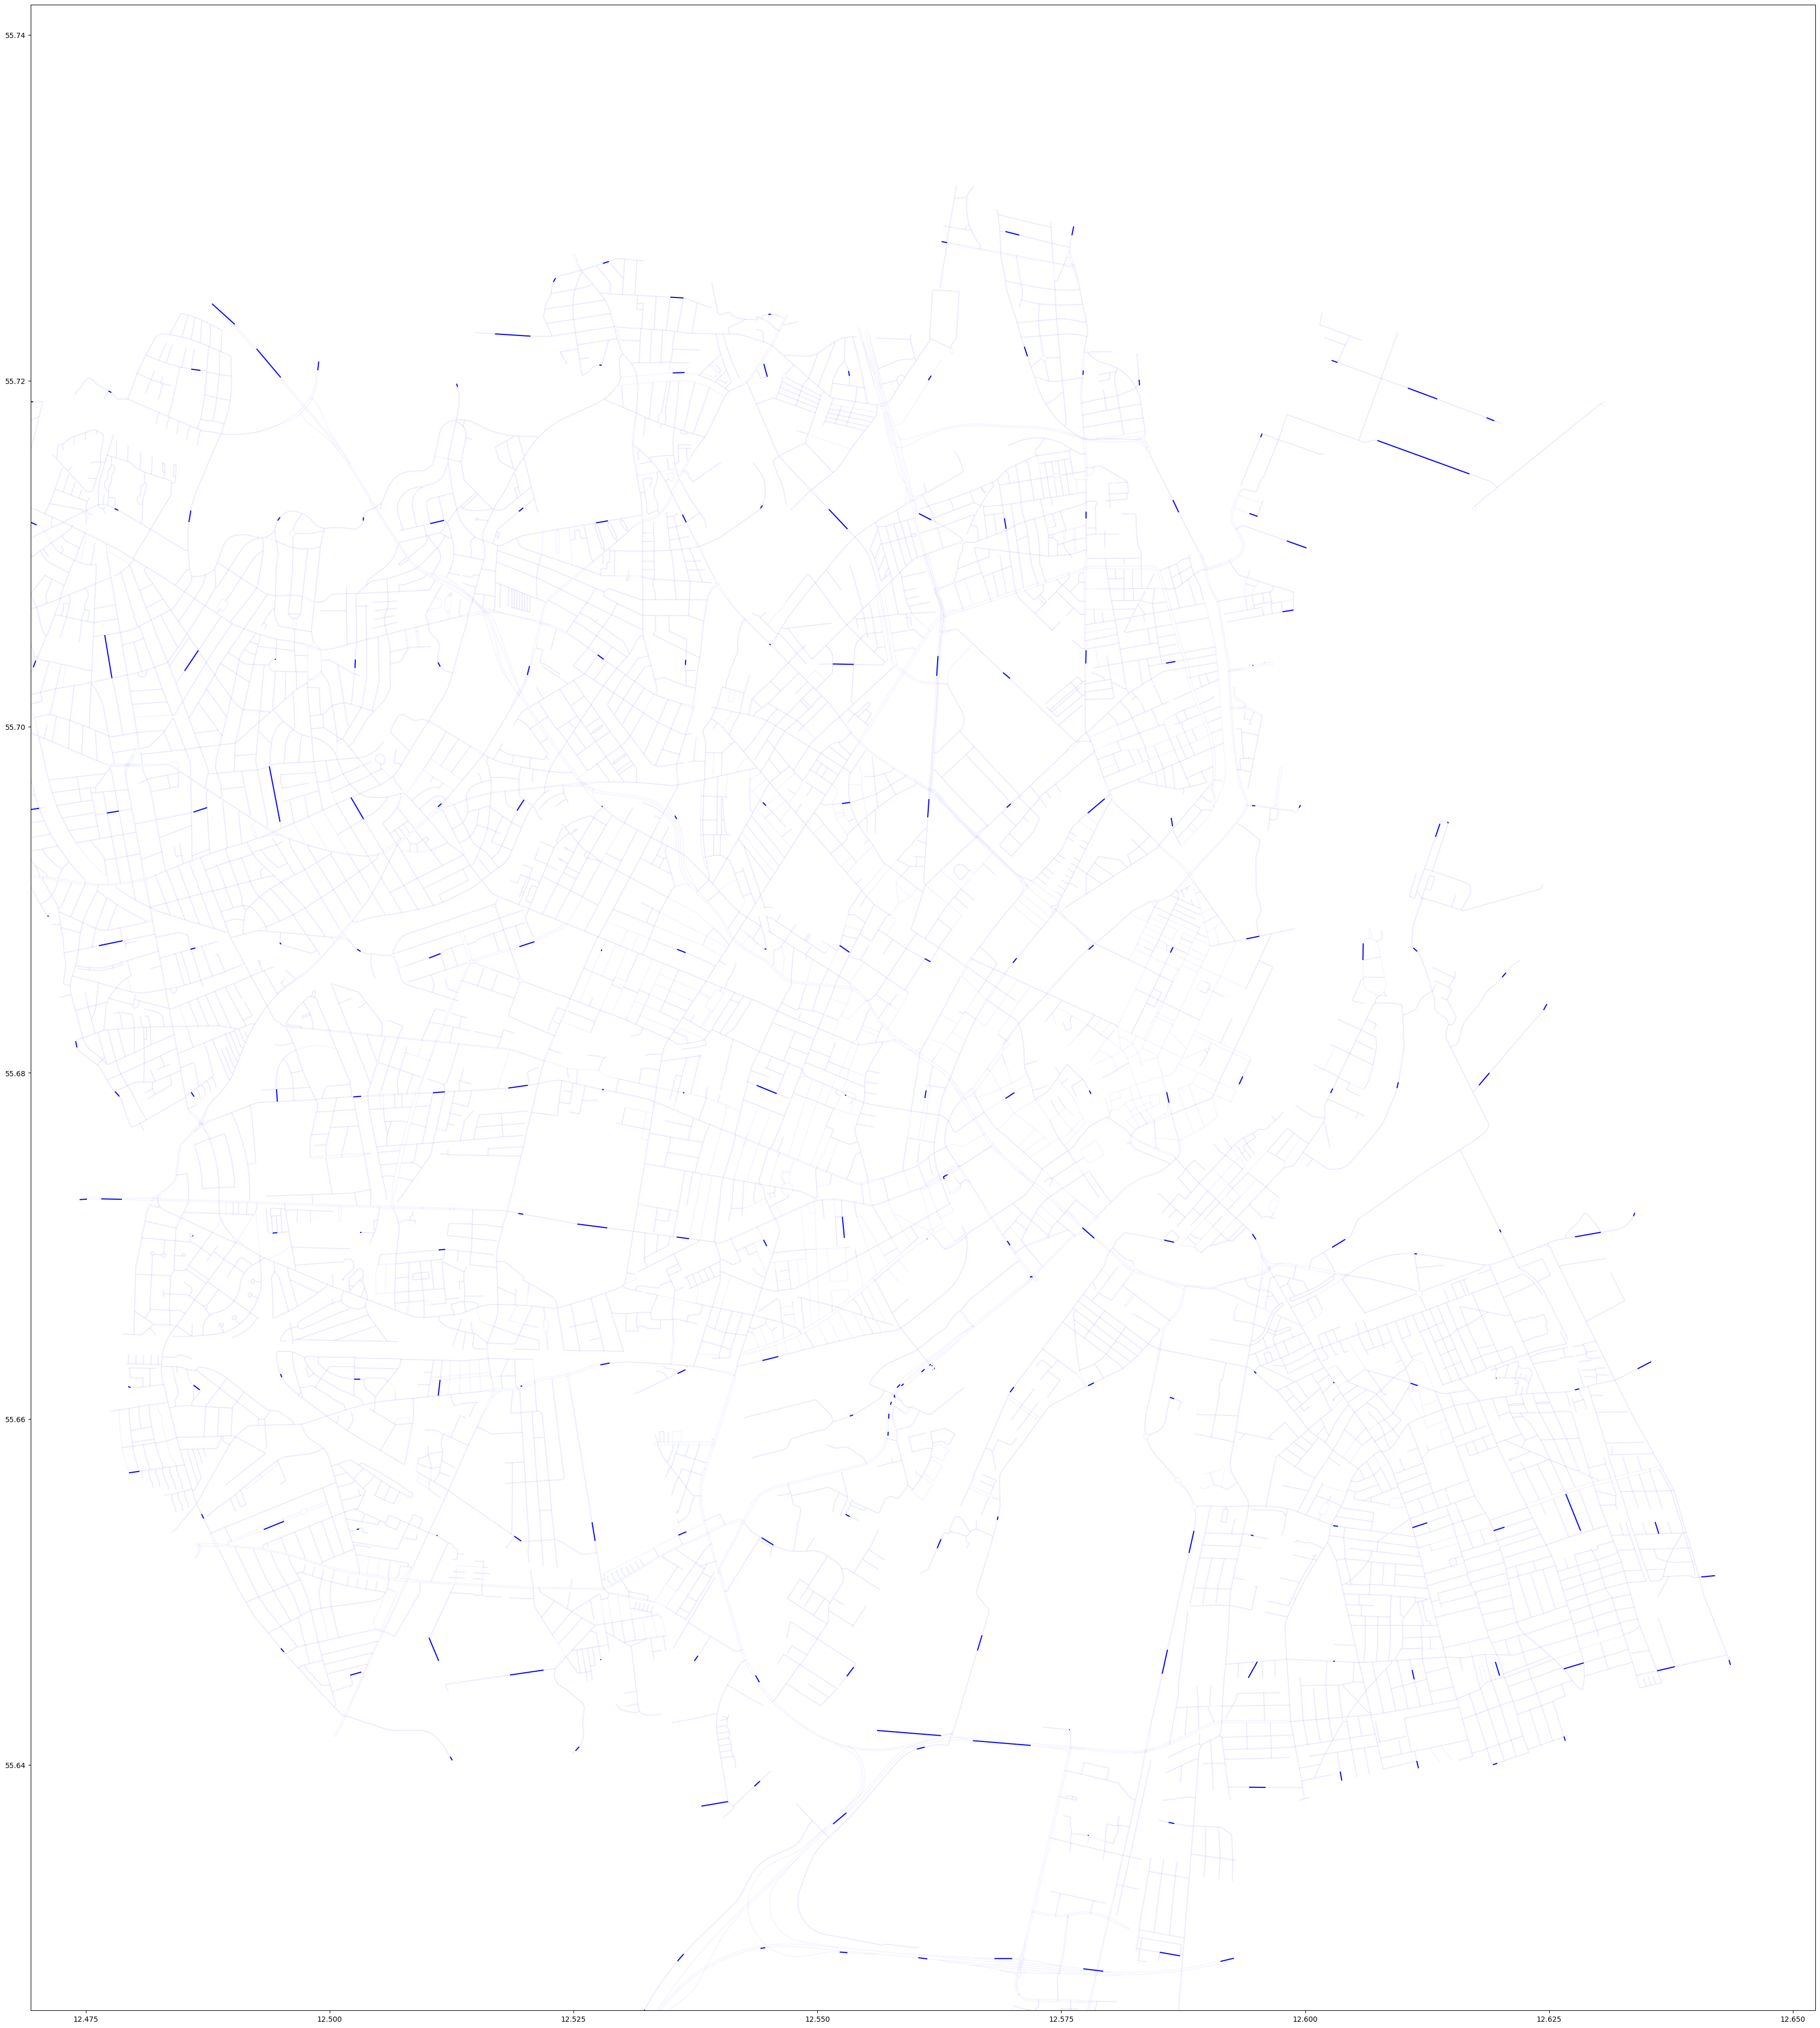

In [127]:
lanes = ox.graph_to_gdfs(G_carall, nodes=False) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ac = [0.04 if (pop_len_attr_dict[k]) == pop_den_attr_unassigned else 1.0 for k in pop_len_attr_dict]
ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#poplanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))
plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

## Plot nearest edges, including visualisation of population density described with dots

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


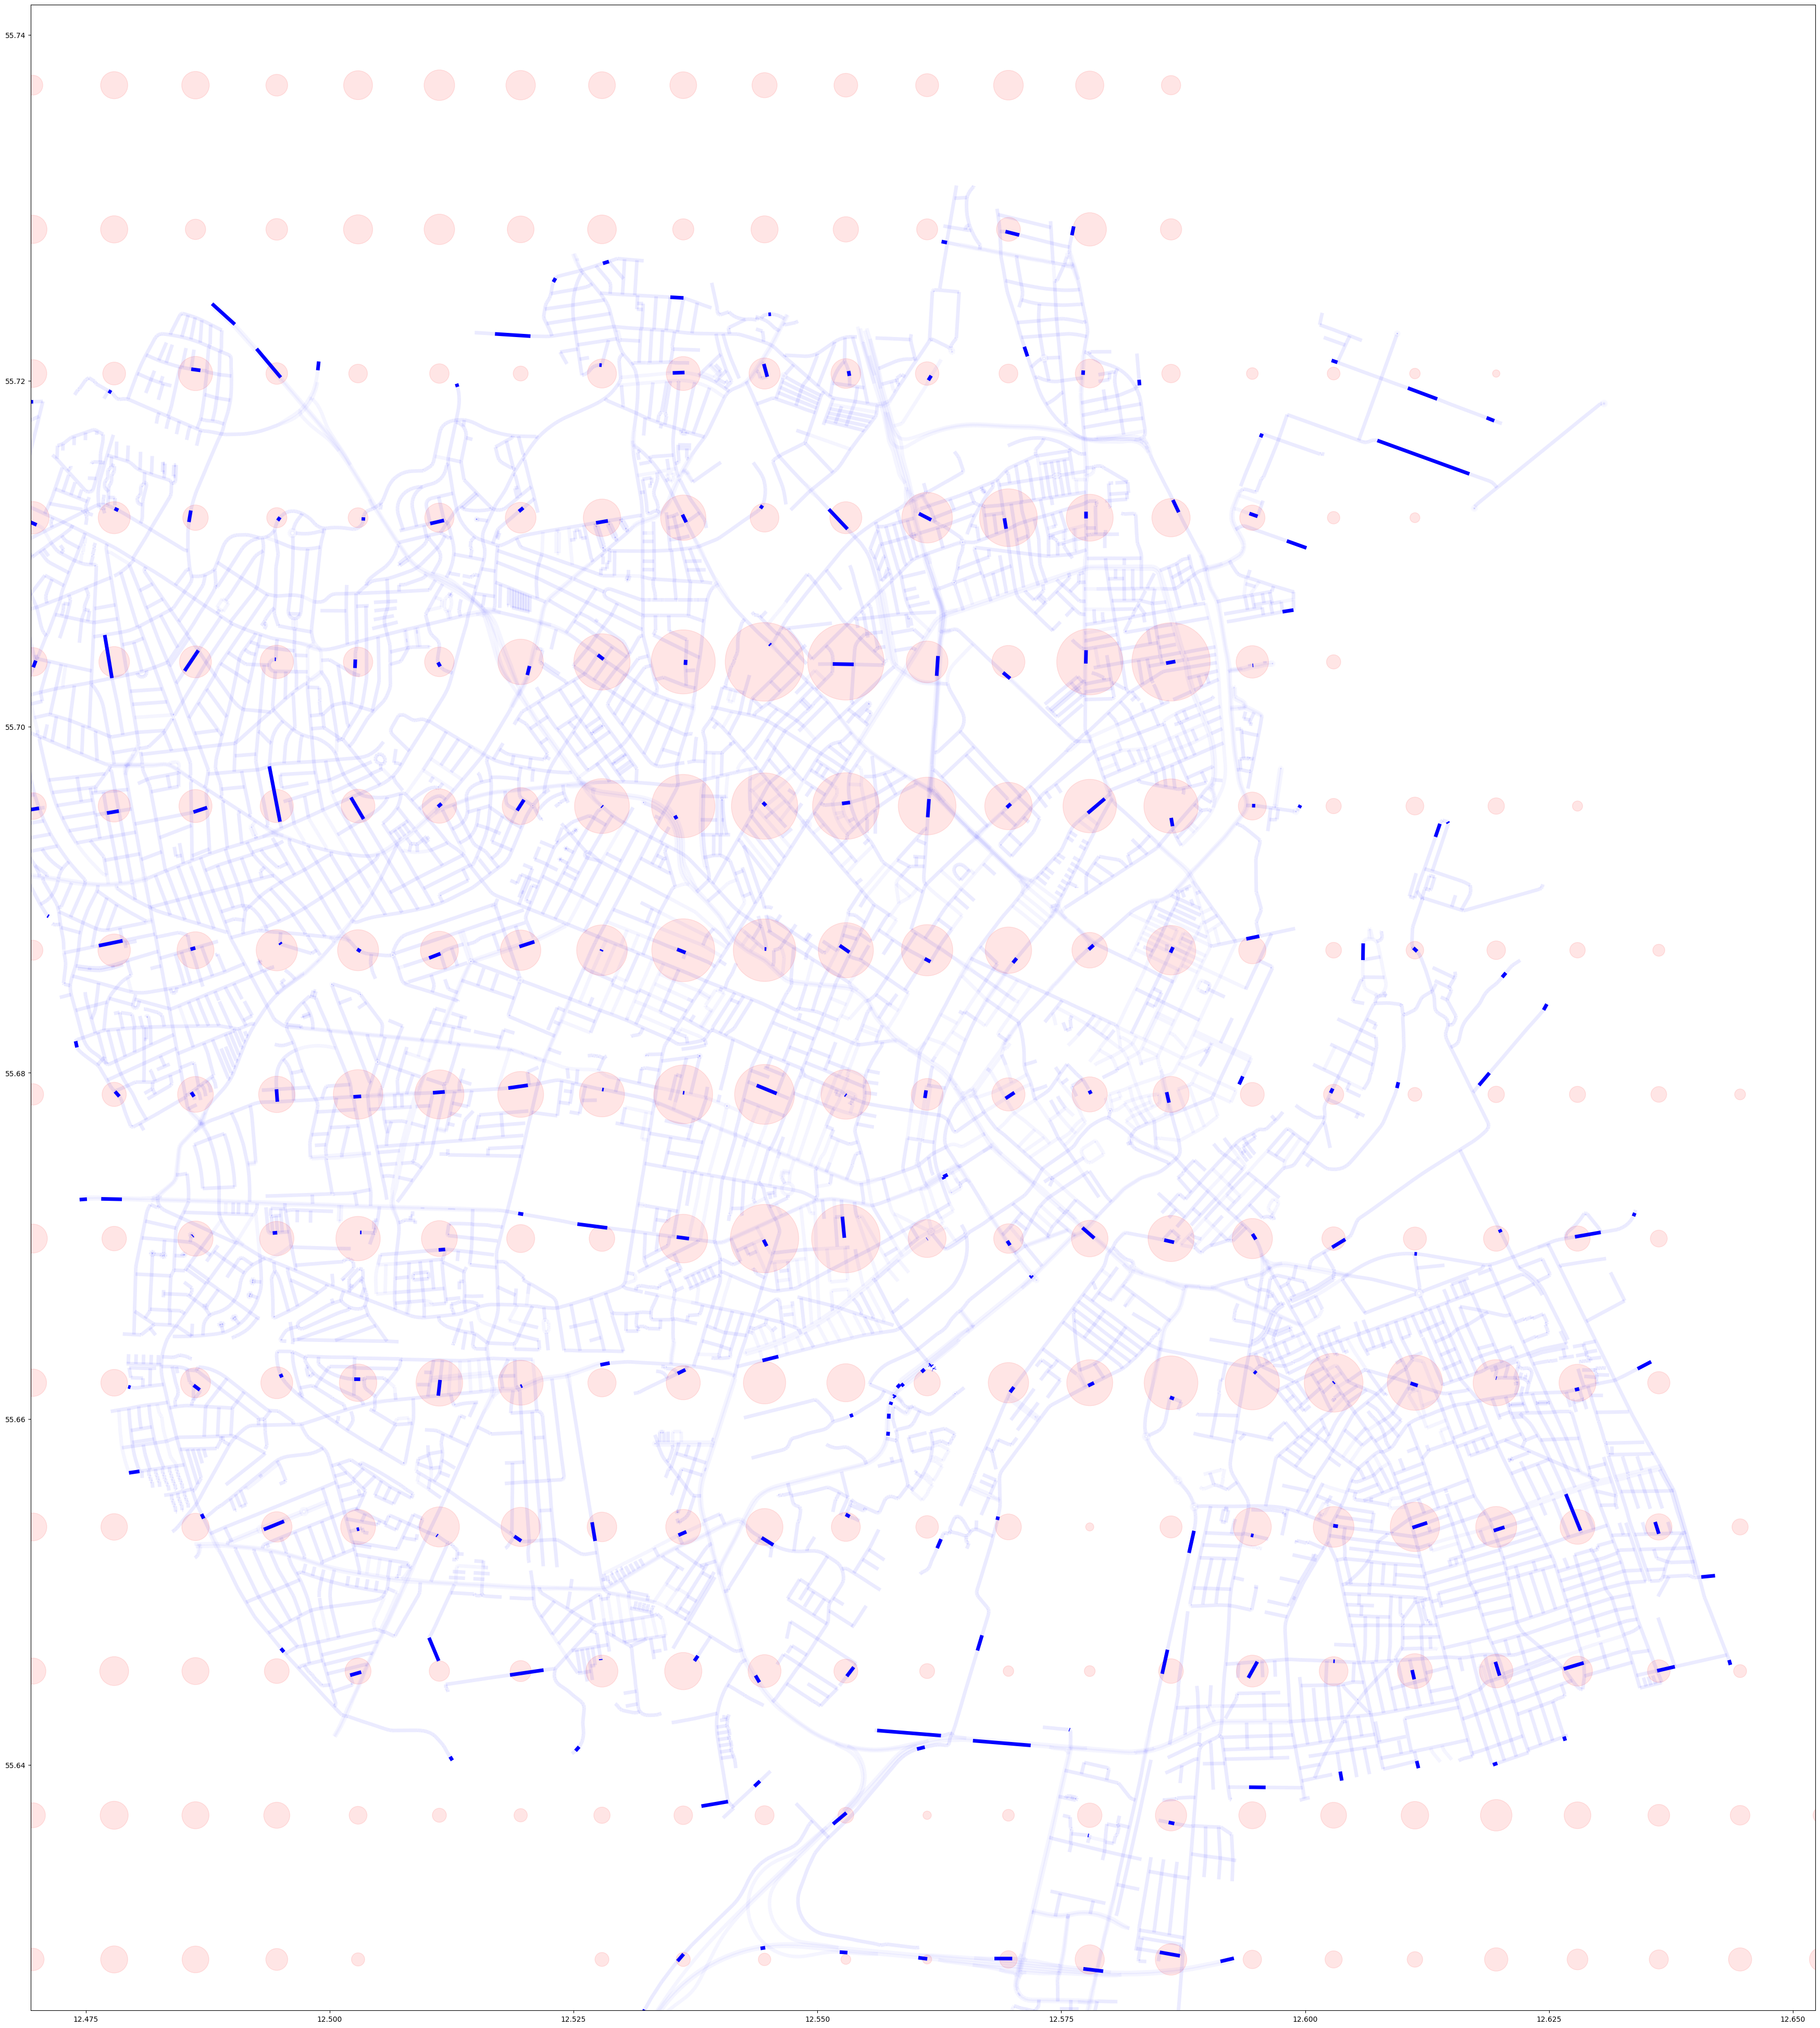

In [197]:
poplanes = gpd.GeoDataFrame(pop_den_df, geometry=gpd.points_from_xy(pop_den_df['long'], pop_den_df['lat']))
lanes = ox.graph_to_gdfs(G_carall, nodes=False) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ac = [0.04 if (pop_len_attr_dict[k]) == pop_den_attr_unassigned else 1.0 for k in pop_len_attr_dict]
ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
lw = [k/3 for k in pop_den_df['pop_den'] ]

poplanes.plot(ax=ax, color='red', markersize = lw, alpha = 0.1)
lanes.plot(ax=ax, color='blue', alpha= ac, linewidth = 5)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))
plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

# Calculate betweenness centrality for pop_den_attr

In [128]:
btw_pop_den_attr = nx.edge_betweenness_centrality(G_carall,  weight='pop_den_attr')

In [130]:
fn = lambda value, x_max, x_min: (value - x_min) / (x_max - x_min)
btw_pop_den_attr_norm = btw_pop_den_attr 
# In each inner dict

# find min and max values
max_x = max(btw_pop_den_attr .values())
min_x = min(btw_pop_den_attr .values())

# normalize each value in the dict
for k in btw_pop_den_attr:
    btw_pop_den_attr_norm[k] = fn(btw_pop_den_attr[k], max_x, min_x)

In [138]:
with open('../../bikenwgrowth_external/data/copenhagen/bikedata/btw_pop_den_attr.pickle', 'wb') as y:
    pickle.dump(btw_pop_den_attr_norm, y)

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


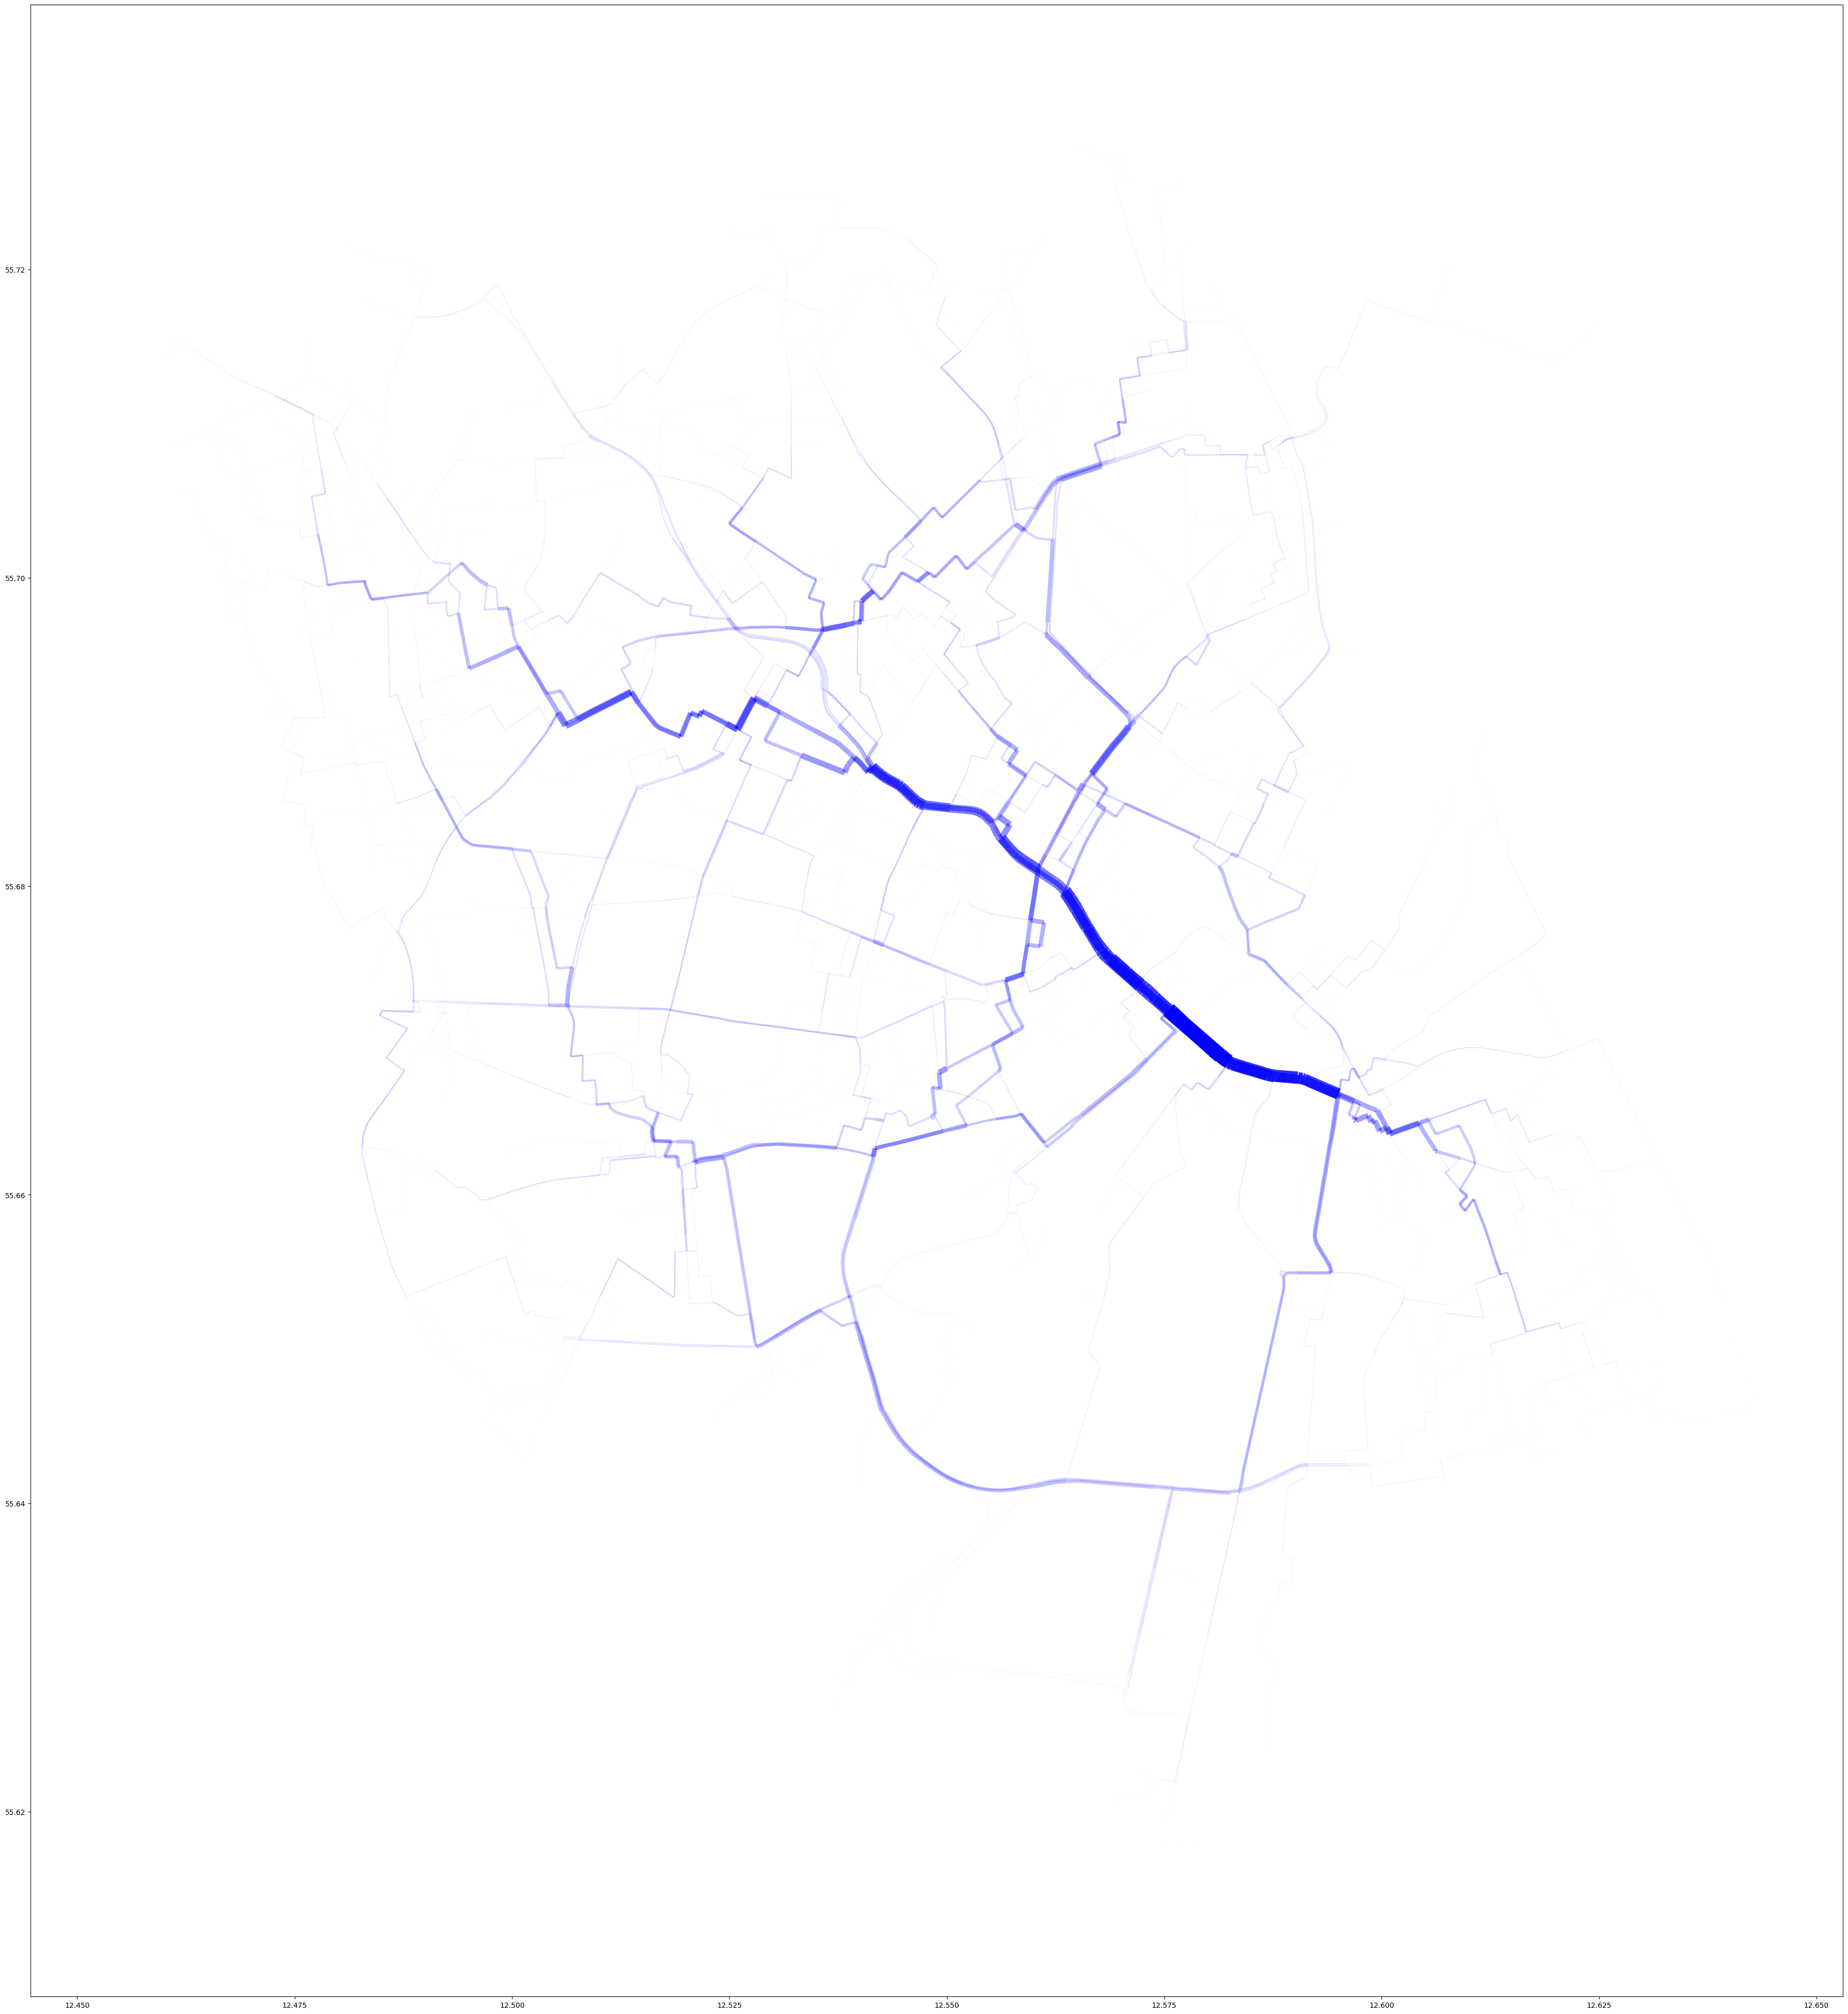

In [137]:
#This plot is edge betweenness centrality based on the 'bc_len_attr' attribute 
lanes = ox.graph_to_gdfs(G_carall, nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ac = [btw_pop_den_attr_norm[k] for k in btw_pop_den_attr_norm]
#ac = [0.08 if (edges_dict[k]) == meancountfraction else 0.8 for k in edges_dict]
lc = [btw_pop_den_attr_norm[k]*20 for k in btw_pop_den_attr_norm]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac, linewidth = lc)


plt.show()

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


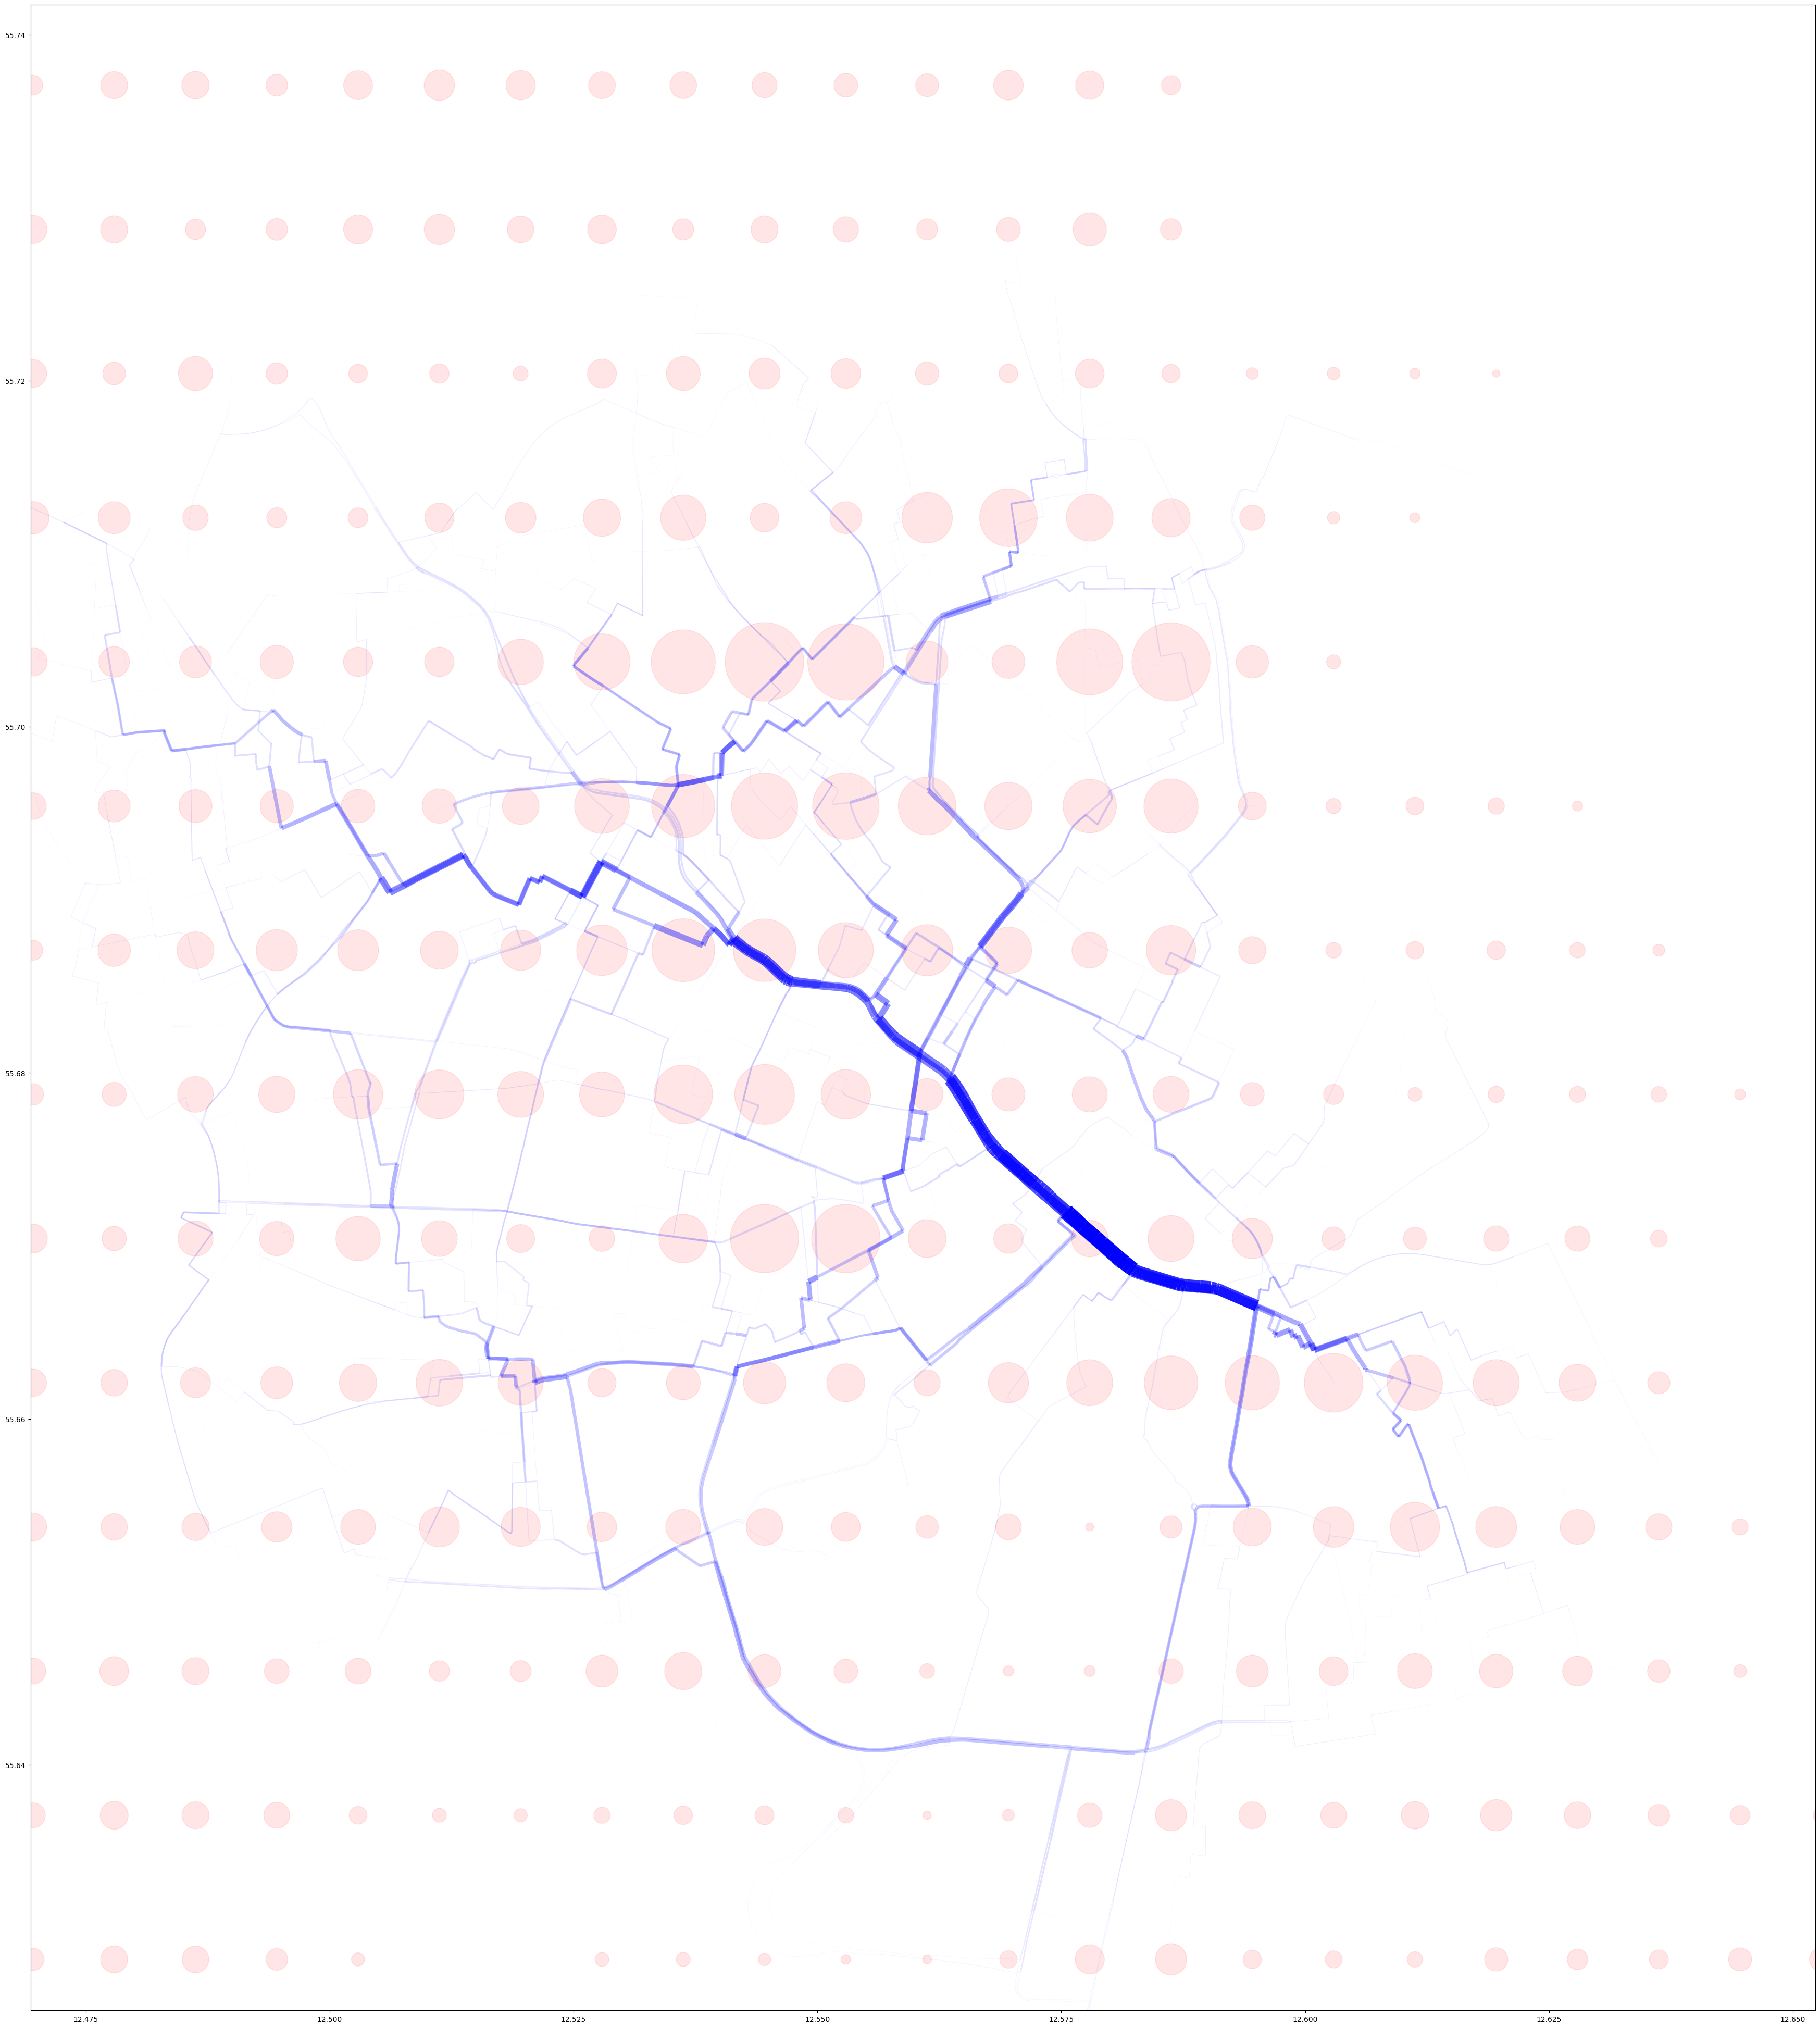

In [196]:
#This plot is edge betweenness centrality based on the 'bc_len_attr' attribute 
lanes = ox.graph_to_gdfs(G_carall, nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
lw = [k/3 for k in pop_den_df['pop_den'] ]


ac = [btw_pop_den_attr_norm[k] for k in btw_pop_den_attr_norm]
#ac = [0.08 if (edges_dict[k]) == meancountfraction else 0.8 for k in edges_dict]
lc = [btw_pop_den_attr_norm[k]*20 for k in btw_pop_den_attr_norm]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
poplanes.plot(ax=ax, color='red', markersize = lw, alpha = 0.1)
lanes.plot(ax=ax, color='blue', alpha= ac, linewidth = lc)

plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

In [223]:
popden = pd.DataFrame.from_dict([pop_len_attr_dict])

In [239]:
popd = popden.T

In [242]:
popd.rename(columns={"0": "a"})

0
(118725, 2512504197, 0)       23.632491
(118725, 298795891, 0)        96.225755
(118730, 1051183834, 0)       74.478717
(118731, 1051183809, 0)       41.599465
(118732, 6534097568, 0)        1.421720
...                                 ...
(10302263881, 298446924, 0)    3.039762
(10302263881, 9931345969, 0)   3.039762
(10302300473, 833414483, 0)    3.039762
(10302313294, 4252972104, 0)   3.039762
(10302313294, 8563517, 0)      3.039762

[65582 rows x 1 columns]

RangeIndex(start=0, stop=1, step=1)

In [236]:
pop_len_attr_dict

{(118725, 2512504197, 0): 23.63249051808012,
 (118725, 298795891, 0): 96.22575499902864,
 (118730, 1051183834, 0): 74.47871696584001,
 (118731, 1051183809, 0): 41.5994653461769,
 (118732, 6534097568, 0): 1.4217196701836634,
 (118732, 283603631, 0): 7.410251937044861,
 (118733, 4924695578, 0): 3.947122610045356,
 (118735, 8977396171, 0): 8.865923695084938,
 (118735, 4393215585, 0): 13.181449535940587,
 (118737, 2935851405, 0): 0.7871574282933995,
 (118738, 1051990746, 0): 0.4736583277038381,
 (118739, 588481105, 0): 1.1470409851779484,
 (118747, 6651812229, 0): 12.199587613328749,
 (118747, 1052455426, 0): 8.053296804252318,
 (118748, 1051183765, 0): 37.56973247168408,
 (118749, 1052455244, 0): 101.2249817858467,
 (118750, 1052455372, 0): 63.10360979002555,
 (118751, 118747, 0): 3.039761961879878,
 (118751, 3574460115, 0): 3.039761961879878,
 (118751, 6651812218, 0): 3.039761961879878,
 (118752, 1052455274, 0): 3.039761961879878,
 (118753, 7640808912, 0): 3.039761961879878,
 (118754, 10

In [201]:
pop_den_attr_unassigned

0.10040273320068874

In [133]:
Audio(sound_file, autoplay=True)